#### About
Face emotion recognition.

Dataset used - FER 2013 (https://www.kaggle.com/datasets/msambare/fer2013/code)


- The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories 

- 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral. 

- The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

- Brief - An initial method would involve creating train and val dataloaders and then taking a pretrained base model and tweaking its head to predict 7 classes. During the prediction stage, Only the detected face should be passed to the trained model on cropped FER 2013 faces dataset for enhanced accuracy.




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
#importing libraries
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import cv2
import glob
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
from torchsummary import summary


In [2]:
# os.chdir('/content/drive/MyDrive/dataset')
# !unzip FER.zip

In [3]:
print(torch.cuda.is_available())
#device = torch.device("cpu")
device = torch.device("cuda")

True


In [4]:
dataset_path = "/content/drive/MyDrive/dataset"
class_names = os.listdir(dataset_path+"/train")
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


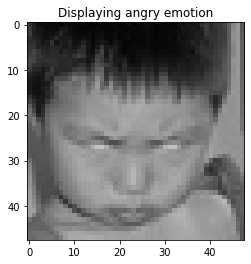

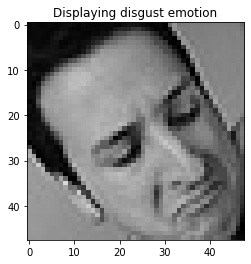

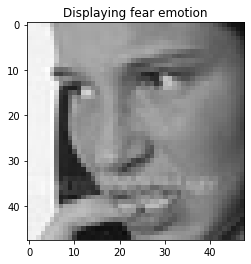

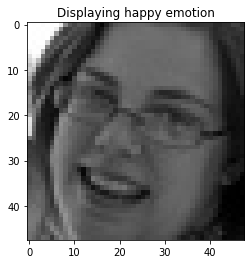

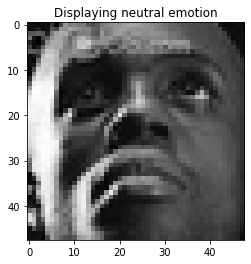

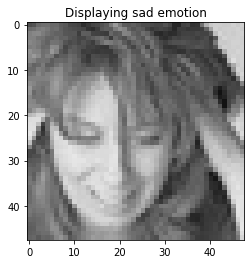

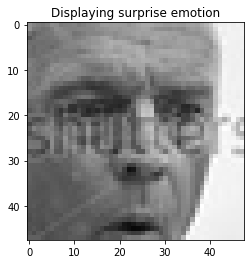

In [5]:
#Displaying one image for each emotion in train directory
emotions = []
for file_name in glob.glob(dataset_path+'/train/*/*'):
    emotion = file_name.split('/')[-2]
    if emotion not in emotions:
        img = cv2.imread(file_name)
        plt.imshow(img)
        plt.title("Displaying {} emotion".format(emotion))
        plt.show()
    emotions.append(emotion)


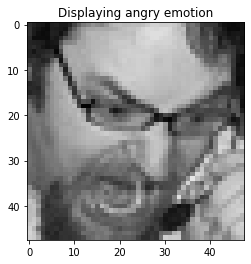

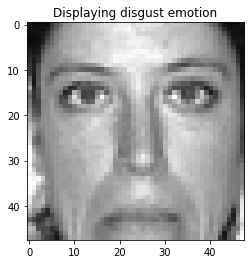

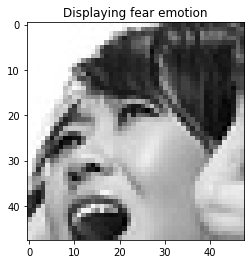

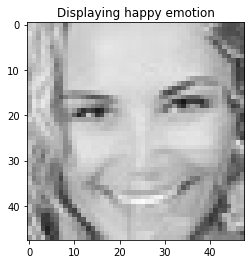

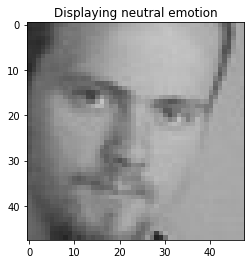

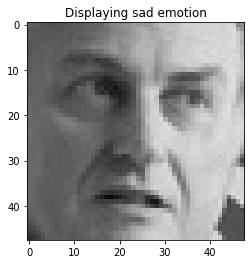

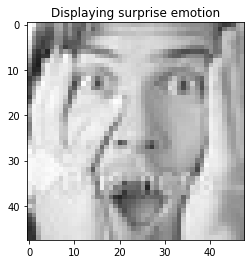

In [6]:
#Displaying one image for each emotion in val directory
emotions = []
for file_name in glob.glob(dataset_path+'/test/*/*'):
    emotion = file_name.split('/')[-2]
    if emotion not in emotions:
        img = cv2.imread(file_name)
        plt.imshow(img)
        plt.title("Displaying {} emotion".format(emotion))
        plt.show()
    emotions.append(emotion)


In [7]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((48, 48))])

In [8]:
#creating train data loaders
train_dataset = ImageFolder(dataset_path+'/train',transform)
train_loader = DataLoader(dataset=train_dataset,batch_size=2048*6)
#creating val data loaders
val_dataset = ImageFolder(dataset_path+'/test',transform)
val_loader = DataLoader(dataset=val_dataset,batch_size=2048)


In [9]:
for batch in train_loader:
    print(batch[0].shape,batch[1].shape)
    break

torch.Size([12288, 3, 48, 48]) torch.Size([12288])


In [10]:
classes_mappings = train_dataset.class_to_idx
#reversing
reversed_mappings = {v:k for k,v in classes_mappings.items()}
print(reversed_mappings)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [11]:
class FaceEmotionClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images= images.to(device)
        labels= labels.to(device) 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        images= images.to(device)
        labels= labels.to(device) 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}],  train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [12]:
#Architecture based on Deep Emotion - https://arxiv.org/abs/1902.01019
class Deep_Emotion(FaceEmotionClassificationBase):
    def __init__(self):

        super(Deep_Emotion,self).__init__()
        self.conv1 = nn.Conv2d(3,10,3)
        self.conv2 = nn.Conv2d(10,10,3)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(10,10,3)
        self.conv4 = nn.Conv2d(10,10,3)
        self.pool4 = nn.MaxPool2d(2,2)

        self.norm = nn.BatchNorm2d(10)

        self.fc1 = nn.Linear(810,50)
        self.fc2 = nn.Linear(50,7)

        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def attention(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 640)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self,input):
        out = self.attention(input)

        out = F.relu(self.conv1(out))
        out = self.conv2(out)
        out = F.relu(self.pool2(out))

        out = F.relu(self.conv3(out))
        out = self.norm(self.conv4(out))
        out = F.relu(self.pool4(out))

        out = F.dropout(out)
        out = out.view(-1, 810)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [13]:
#moving tensor to device
model = Deep_Emotion().to(device)


In [14]:
#evaluation function
#@torch.no_grad
def evaluate(model,val_loader):
    model.eval()
    outputs =[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [15]:
summary(model,input_size=(3,48,48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 42, 42]           1,184
         MaxPool2d-2            [-1, 8, 21, 21]               0
              ReLU-3            [-1, 8, 21, 21]               0
            Conv2d-4           [-1, 10, 17, 17]           2,010
         MaxPool2d-5             [-1, 10, 8, 8]               0
              ReLU-6             [-1, 10, 8, 8]               0
            Linear-7                   [-1, 32]          20,512
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10           [-1, 10, 46, 46]             280
           Conv2d-11           [-1, 10, 44, 44]             910
        MaxPool2d-12           [-1, 10, 22, 22]               0
           Conv2d-13           [-1, 10, 20, 20]             910
           Conv2d-14           [-1, 10,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [16]:
def fit(num_epochs, model, train_loader,val_loader,opt=optimizer):
    history=[]
    for epoch in range(num_epochs):
        model.train()
        train_losses=[]
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model,val_loader)
        result['train_loss'] = sum(train_losses)/len(train_losses)
        model.epoch_end(epoch,result)
        history.append(result)
    
    return history


In [17]:
num_epochs=50
history =fit(num_epochs, model, train_loader,val_loader,opt=optimizer)

Epoch [0],  train_loss: 2.1489, val_loss: 1.9398, val_acc: 0.1274
Epoch [1],  train_loss: 1.9092, val_loss: 1.9373, val_acc: 0.1298
Epoch [2],  train_loss: 1.8439, val_loss: 1.9350, val_acc: 0.1525
Epoch [3],  train_loss: 1.8015, val_loss: 1.9326, val_acc: 0.1694
Epoch [4],  train_loss: 1.7771, val_loss: 1.9304, val_acc: 0.1759
Epoch [5],  train_loss: 1.7696, val_loss: 1.9280, val_acc: 0.1768
Epoch [6],  train_loss: 1.7705, val_loss: 1.9260, val_acc: 0.1763
Epoch [7],  train_loss: 1.7754, val_loss: 1.9242, val_acc: 0.1766
Epoch [8],  train_loss: 1.7750, val_loss: 1.9224, val_acc: 0.1766
Epoch [9],  train_loss: 1.7753, val_loss: 1.9205, val_acc: 0.1770
Epoch [10],  train_loss: 1.7727, val_loss: 1.9188, val_acc: 0.1770
Epoch [11],  train_loss: 1.7673, val_loss: 1.9177, val_acc: 0.1782
Epoch [12],  train_loss: 1.7641, val_loss: 1.9154, val_acc: 0.1796
Epoch [13],  train_loss: 1.7603, val_loss: 1.9118, val_acc: 0.1808
Epoch [14],  train_loss: 1.7590, val_loss: 1.9081, val_acc: 0.1825
Epoch

Text(0.5, 1.0, 'Accuracy plot')

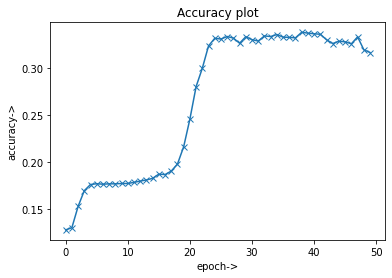

In [19]:
# plotting the curves
accuracy = [result['val_acc'] for result in history]
plt.plot(accuracy,'-x')
plt.xlabel('epoch->')
plt.ylabel('accuracy->')
plt.title('Accuracy plot')

Text(0.5, 1.0, 'Accuracy plot')

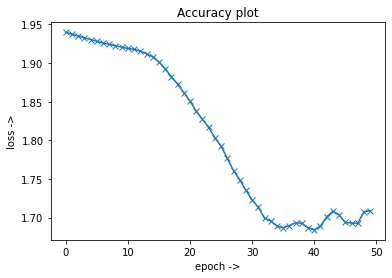

In [20]:
# plotting the curves
loss = [result['val_loss'] for result in history]
plt.plot(loss,'-x')
plt.xlabel('epoch ->')
plt.ylabel('loss ->')
plt.title('Accuracy plot')

In [21]:
# saving the model by saving state_dict
torch.save(model.state_dict(), 'face_emotion_deep_emotion.pth')

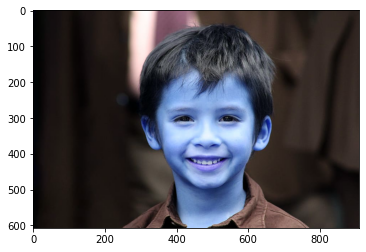

In [22]:
# prediction on a test image
test_img = cv2.imread('/content/test1.jpg')
plt.imshow(test_img)
plt.show()

In [23]:
#loading face detector
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
gray_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
face_detected = face_detector.detectMultiScale(gray_img,1.1,4)
for x,y,w,h in face_detected:
  gray_img_roi = gray_img[y:y+h,x:x+w]
  color_img_roi = test_img[y:y+h,x:x+w]
  cv2.rectangle(test_img,(x,y),(x+w,y+h),(0,255,0),5)
  faces = face_detector.detectMultiScale(gray_img_roi)
  if len(faces)!=0:
    for ex,ey,ew,eh in faces :
      face_roi = color_img_roi[ey:ey+eh,ex:ex+ew] 

In [41]:
cropped_img = cv2.resize(face_roi,(48,48))
cropped_img=cropped_img.transpose(2,0,1)
cropped_img= np.expand_dims(cropped_img,axis=0)#building a fourth dim for batch=1
img_tensor = torch.from_numpy(cropped_img)
img_tensor = img_tensor.type(torch.FloatTensor)
cropped_img = img_tensor.to(device)
output = model(cropped_img)
pred_prob = F.softmax(output,dim=1)
pred_label = torch.argmax(pred_prob)
print("Predicted label is {}".format(reversed_mappings[pred_label.item()]))

Predicted label is happy
